In [3]:
# For SDV, torch version below 2.0 and above 1.8
!pip install torch==1.13.1
! pip install sdv
! pip install faker
! pip install realtabformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.1 requires torch==2.0.0, but you have torch

In [34]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from collections import OrderedDict
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer, GaussianCopulaSynthesizer
import torch
import re
from sdv.metadata import SingleTableMetadata
from realtabformer import REaLTabFormer
 


class Generator:

    def __init__(self, data, architecture, n_samples, num_epochs=None, num_bootstrap = None ,categorical_columns=None, sensitive_columns=None):

        """
        :param n_epochs: the number of epochs used for training, default is 200
        :param num_bootstraps: number of bootstraps for the RealTabFormer, default is 500
        :param n_samples: the number of rows to generate
        :param architecture: the chosen architecture, one of ['CTGAN', 'GaussianCopula', 'RealTabFormer']
        :param data: the data that should be trained on, should be in a pandas dataframe
        :param categorical_columns: a list with categorical columns
        :param sensitive_columns: a dict with sensitive columns and what  category they belong to
        The categories can be found in the faker_categorical function

        The metadata: an sdv metadata object required to call CTGAN and other methods
        Also required for similarity checks
        """
        if num_epochs is not None:
          self.num_epochs = num_epochs
        else: 
          # Default value for RealTabFormer and could be enough for CTGAN
          self.num_epochs = 200
        if num_bootstrap is not None:
          self.num_bootstrap = num_bootstrap
        else: 
          # Set to default for RealTabFormer
          self.num_bootstrap = 500 
        self.n_samples = n_samples
        if architecture in ['CTGAN', 'GaussianCopula', 'RealTabFormer']:
            self.architecture = architecture
        else:
            print('The requested architecture is not available')
            raise ValueError
        print('Retrieving metadata, check with generator.metadata')
        self.data = data
        self.metadata = self.create_metadata()
        self.categorical_columns = categorical_columns
        self.sensitive_columns = sensitive_columns

    def create_metadata(self):
        metadata = SingleTableMetadata()
        metadata.detect_from_dataframe(data=self.data)
        return metadata

    def generate(self):
        """
        Based on the chosen architecture, this function returns synthetically generated data
        :return: synthetic data, a pandas dataframe
        """

        #  TODO: Add more generators, especially PATEGAN or other differentially private ones synthcity seems to have
        #  implementations of these, but I have not been able to import their library

        if self.architecture == "CTGAN":
            model = CTGANSynthesizer(metadata=self.metadata, epochs=self.num_epochs, verbose=True)
            model.fit(self.data)
            synth_data = model.sample(self.n_samples)

        elif self.architecture == "GaussianCopula":
            model = GaussianCopulaSynthesizer(metadata=self.metadata)
            model.fit(self.data)
            synth_data = model.sample(self.n_samples)
        elif self.architecture == "RealTabFormer":
            model = REaLTabFormer(
                      model_type="tabular",
                      epochs = self.num_epochs,
                      gradient_accumulation_steps=4,
                      # Output log each 2O steps
                      logging_steps=20)
            model.fit(self.data, num_bootstrap = self.num_bootstrap)
            synth_data = model.sample(n_samples = len(data))


        return synth_data

    def faker_categorical(self, seed=None):
        """
        Instantiates Faker, generates fake data for it
        WARNING: data generated here should not be used for ML models
        :param seed: int, random seed, defaults
        """

        # TODO: Find a way to make this generalizable, f.e. create many attributes, and return the ones asked

        seed = seed or random.seed()
        # We can initialize the faker with multiple locations: can now draw addresses and names from
        # Germany, US, UK, Spain, France, Italy. Either just a list => all equal weights, or an ordered
        # dictionary in which weights can be specified.
        locale_list = ['de_DE', 'en_US', 'en_GB', 'es_ES', 'fr_FR', 'it_IT']
        fake = Faker(locale_list)
        fake.seed_instance(seed)
        # check whether the ID generated is already in use
        used_ids = set()
        output = []
        for i in range(self.n_samples):
            # select a locale at random => will allow us to generate internally consistent city-country pairs
            # or name/email pairs. Problem is that not all countries might be able to generate all of these
            # attributes. For example Belgium can't create IP-addresses
            locale = np.random.choice(locale_list)
            while True:
                new_id = fake.random_int(min=1, max=self.n_samples)
                if new_id not in used_ids:
                    used_ids.add(new_id)
                    break

            gender = np.random.choice(["Male", "Female"], p=[0.5, 0.5])
            # this works, but it's technical debt, talk to Léo about it
            if gender == "male":
                first_name = fake[locale].first_name_male()
            else:
                first_name = fake[locale].first_name_female()
            last_name = fake[locale].last_name()
            row = {
                "id": new_id,
                "first_name": first_name,
                "last_name": last_name,
                # take everything before @, and replace with first name.lastname
                "email": re.sub(r'^(.*?)@', first_name + "." + last_name + "@", fake[locale].free_email()),
                "gender": gender,
                "ip_address": fake[locale].ipv4_private(),
                "nationality": fake[locale].current_country(),
                "city": fake[locale].city()
            }
            output.append(row)

        df = pd.DataFrame(output, columns=self.sensitive_columns)
        return df

In [65]:
from __future__ import annotations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sdv.evaluation.single_table import evaluate_quality

# TODO: ML model performance 


class SimilarityCheck:

    '''
    Check the quality of the synthetic data both visually and with metrics
    '''

    def __init__(self, real_data, synthetic_data, cat_cols, metadata):
        self.real_data = real_data
        self.synthetic_data = synthetic_data
        if cat_cols is not None:
          self.cat_cols = cat_cols
        else:
          self.cat_cols = []
        self.metadata = metadata


    def comparison_columns(self):
        '''
        :return: the KL divergence for numerical variables...
        tested and works
        '''
        quality_report = evaluate_quality(
          real_data=self.real_data,
          synthetic_data=self.synthetic_data,
          metadata=self.metadata)
        print(quality_report)
        print(quality_report.get_details(property_name='Column Shapes'))


    def visual_comparison_columns(self):
        '''
        Plot data in one of three ways:
        1) numeric columns are plotted using the densities
        2) categorical columns with limited categories are plotted with bar plots
        3) categorical columns with many categories do not show the values, if performance looks problematic
        we encourage further exploration of these columns
        '''
        if (self.real_data.columns != self.synthetic_data.columns).all():
            print('Columns in real and synthetic data not the same!')
            return

        fig, ax = plt.subplots(nrows=len(self.real_data.columns), figsize=(10, len(self.real_data.columns)*4))
        fig.tight_layout(pad = 5)
        for i, column in enumerate(self.real_data.columns):
            if column not in self.cat_cols:
                sns.kdeplot(self.real_data[column], ax=ax[i], label='Real', fill=True, color='c')
                sns.kdeplot(self.synthetic_data[column], ax=ax[i], label='Synthetic', fill=True, color='m')
            elif len(self.real_data[column].unique()) <= 5:
                sns.histplot(data = self.real_data,x = column, ax=ax[i],bins = len(self.real_data[column].unique()), label='Real', stat = 'density', color='c',discrete = False,element = 'step')
                sns.histplot(data = self.synthetic_data,x = column, ax=ax[i], bins = len(self.real_data[column].unique()),label='Synthetic', stat = "density", color='m',discrete = False ,element = 'step')
            else:
                sns.histplot(data = self.real_data,x = column, ax=ax[i], label='Real', fill = False,stat = 'density', color='c',discrete = False,element = 'step')
                sns.histplot(data = self.synthetic_data,x = column, ax=ax[i], label='Synthetic', fill = False,stat = "density", color='m',discrete = False ,element = 'step')
                ax[i].set_xticklabels([])
            ax[i].set_title(f'Comparison of {column}')
            ax[i].autoscale_view()
            ax[i].set_xlabel(column)
            ax[i].legend()
        plt.show()

    def compare_correlations(self):
        '''
        Compare correlation matrices
        :return:
        '''
        fig, ax = plt.subplots(figsize=(len(self.real_data.columns), (len(self.real_data.columns))))
        diff_corr = abs(self.real_data.corr() - self.synthetic_data.corr())
        mask = np.tril(np.ones_like(diff_corr, dtype=bool))
        sns.heatmap(diff_corr, mask=mask)
        ax.set_title('Differences in correlation values real and synthetic data')

    def compare_model_performance(self, fitted_model_real, fitted_model_synth, X_test, y_test):
        """
        Method that computes how close the scores of a model trained on the real vs. synthetic
        data are.
        """
        score_real = fitted_model_real.score(X_test, y_test)
        score_synth = fitted_model_synth.score(X_test, y_test)
        print(f"Score on real dataset: {score_real}\nScore on synthetic dataset: {score_synth}")
        return score_real, score_synth


In [36]:
data = pd.read_csv('Subsample_training.csv')

In [39]:
cat_cols = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE', 'Risk_Flag']
sensitive_cols = ["first_name", "last_name", "email", "gender", "ip_address", "nationality", "city"]


generator = Generator(num_epochs=2, n_samples=2000, num_bootstrap = 50 ,architecture='RealTabFormer',
                          data=data.iloc[:,2:],
                          categorical_columns=cat_cols,
                          sensitive_columns=sensitive_cols)

setting bootstrap to 50
Retrieving metadata, check with generator.metadata


In [40]:
synth_data = generator.generate()

Computing the sensitivity threshold...


ate (0.0905) in                     the data. This will not give a reliable early stopping condition. Consider                         using qt_max="compute" argument.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 16...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.023312
std       0.006615
min       0.007160
25%       0.019249
50%       0.022836
75%       0.026078
max       0.040494
dtype: float64
Sensitivity threshold: 0.035275197834753295 qt_max: 0.05


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
20,3.402900
40,2.202200
60,2.054200
80,1.974300
100,1.937300
120,1.914600


  0%|          | 0/990 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1024 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.035275197834753295,                         val_sensitivity: -0.024505050505050512,                             val_sensitivities: [-0.025, -0.023333333333333334, -0.025, -0.024772727272727273, -0.025, -0.025, -0.023068181818181818, -0.025, -0.024924242424242425, -0.02462121212121212, -0.025, -0.025, -0.025, -0.02378787878787879, -0.023068181818181818]


  0%|          | 0/2000 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 2048 samples generated. Sampling efficiency is: 100.0000%


Creating report: 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]



Overall Quality Score: 85.11%

Properties:
Column Shapes: 90.54%
Column Pair Trends: 79.68%
               Column        Metric  Quality Score
0              Income  KSComplement         0.9665
1                 Age  KSComplement         0.9415
2          Experience  KSComplement         0.9535
3     CURRENT_JOB_YRS  KSComplement         0.9755
4   CURRENT_HOUSE_YRS  KSComplement         0.9820
5           Risk_Flag  KSComplement         0.9685
6      Married/Single  TVComplement         0.9920
7     House_Ownership  TVComplement         0.9830
8       Car_Ownership  TVComplement         0.9150
9          Profession  TVComplement         0.9065
10               CITY  TVComplement         0.4105
11              STATE  TVComplement         0.8700


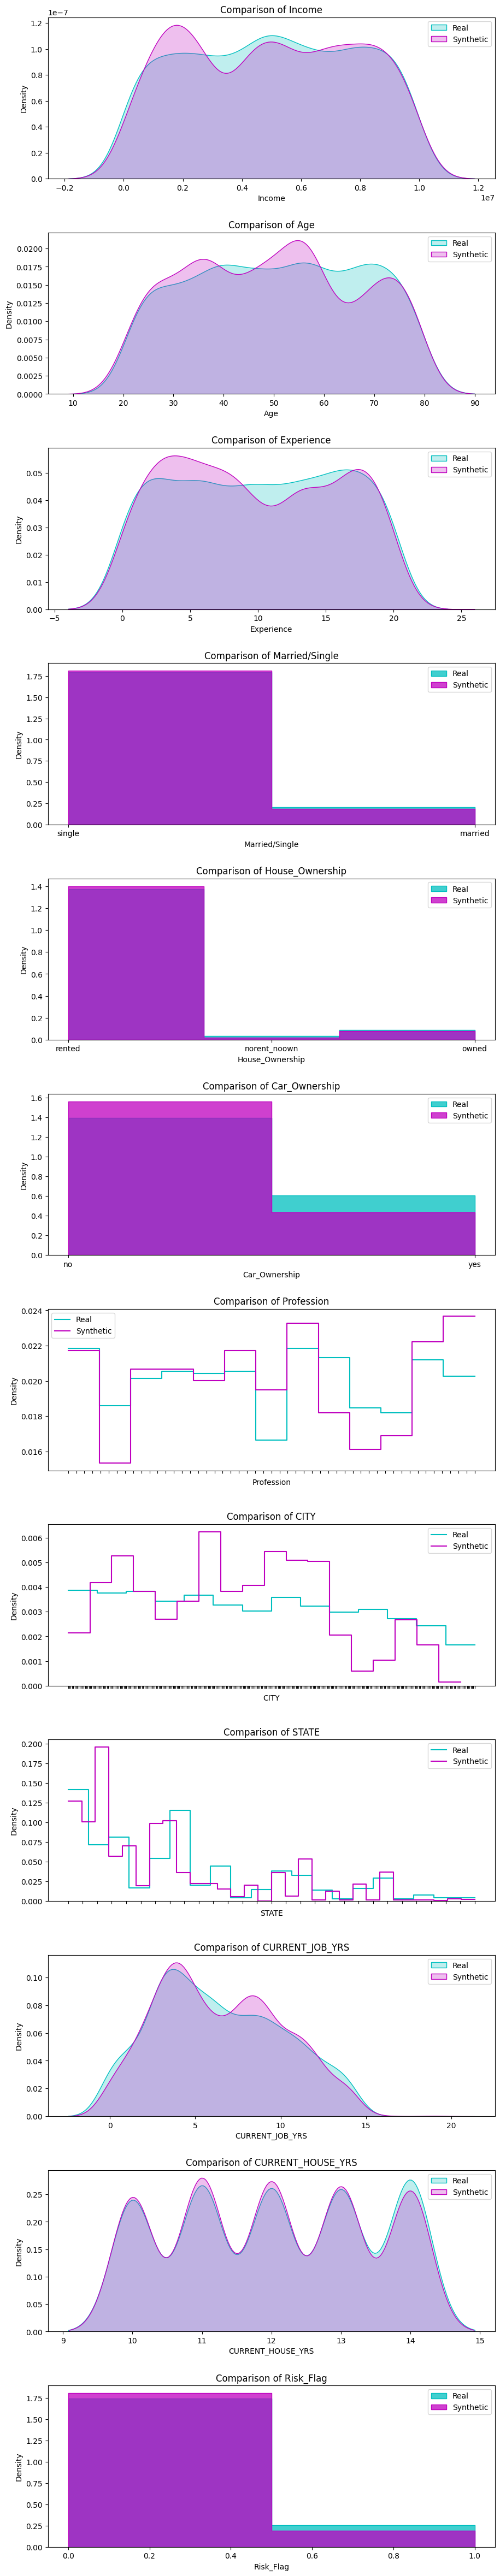

In [68]:
similarity_checker = SimilarityCheck(generator.data, synth_data, cat_cols, generator.metadata)
similarity_checker.comparison_columns()
similarity_checker.visual_comparison_columns()

<ipython-input-43-087b5fa998b1>:96: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  diff_corr = abs(self.real_data.corr() - self.synthetic_data.corr())


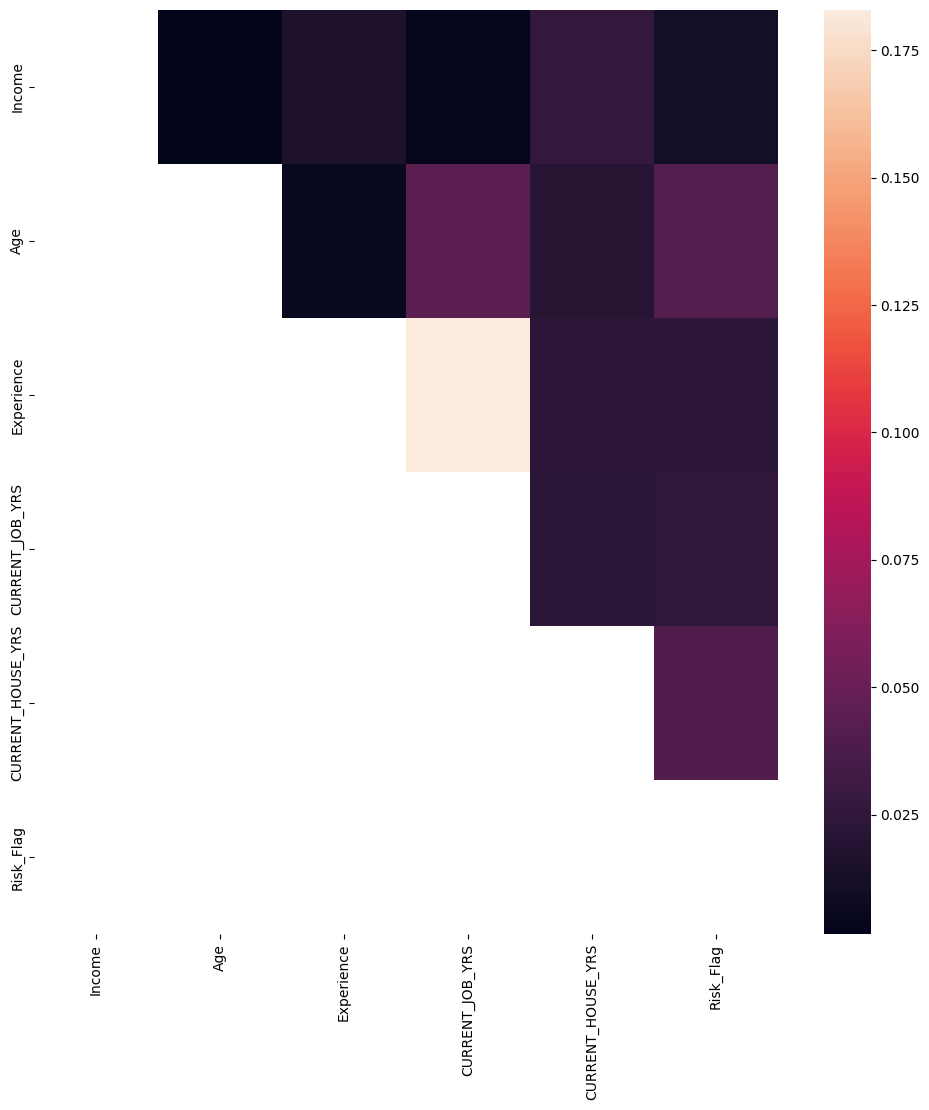

In [45]:
similarity_checker.compare_correlations()

In [52]:
from sdmetrics.reports.single_table import DiagnosticReport

report = DiagnosticReport()

report.generate(generator.data, samples, generator.metadata)

Creating report: 100%|██████████| 4/4 [00:21<00:00,  5.35s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the numerical ranges present in the real data
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data


In [54]:
report.get_results()

{'SUCCESS': ['The synthetic data covers over 90% of the numerical ranges present in the real data',
  'The synthetic data covers over 90% of the categories present in the real data',
  'Over 90% of the synthetic rows are not copies of the real data',
  'The synthetic data follows over 90% of the min/max boundaries set by the real data'],
 'WARNING': [],
 'DANGER': []}

In [53]:
report.get_properties()

{'Coverage': 0.9961109110832901,
 'Synthesis': 0.999,
 'Boundaries': 0.9995833333333334}

## Junk

In [ ]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from collections import OrderedDict
from sdv.evaluation import evaluate
from table_evaluator import TableEvaluator
from src.utils import *
import re
from similarity_check.SimilarityCheck import *
from synthetic_data_generation.generator import *

if __name__ == "__main__":

    ##############################
    # Testing area
    ##############################

    # define path to the data you want to test
    path_test_data = "./Subsample_training.csv"

    # take the comment out to see the first 10 rows of your data

    # indicate which columns are categorical, and which are sensitive
    cat_cols = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE', 'Risk_Flag']
    sensitive_cols = ["first_name", "last_name", "email", "gender", "ip_address", "nationality", "city"]

    my_metadata = {
        'fields':
            {
                'Income': {'type': 'numerical', 'subtype': 'integer'},
                'Age': {'type': 'numerical', 'subtype': 'integer'},
                'Experience': {'type': 'numerical', 'subtype': 'integer'},
                'CURRENT_JOB_YRS': {'type': 'numerical', 'subtype': 'integer'},
                'CURRENT_HOUSE_YRS': {'type': 'numerical', 'subtype': 'integer'},
                'Married/Single': {'type': 'categorical'},
                'House_Ownership': {'type': 'categorical'},
                'Car_Ownership': {'type': 'categorical'},
                'Profession': {'type': 'categorical'},
                'CITY': {'type': 'categorical'},
                'STATE': {'type': 'categorical'},
                'Risk_Flag': {'type': 'boolean'}
            },
        'constraints': [],
        'model_kwargs': {},
        'name': None,
        'primary_key': None,
        'sequence_index': None,
        'entity_columns': [],
        'context_columns': []
    }

    data = get_data(path_test_data)
    # checking that it can deal with nan values
    data.iloc[3, 2] = float("nan")
    print(data.head())
    # create object
    generator = Generator(n_epochs=1, n_samples=100, architecture='CTGAN',
                          data=data,
                          categorical_columns=cat_cols,
                          sensitive_columns=sensitive_cols)
    print("Generating data")
    synth_data = generator.generate().iloc[:, 2:]
    anonymized_data = generator.faker_categorical()
    df = pd.concat([anonymized_data, synth_data], axis=1)
    print(df.columns)
    df.drop(['CITY', 'STATE'], inplace=True, axis=1)
    print(df.head())
    #df.to_csv('synth_data.csv')

    similarity_checker = SimilarityCheck(data.iloc[:, 2:], synth_data, cat_cols, my_metadata)

ModuleNotFoundError: No module named 'sdv.tabular'

In [49]:
from realtabformer import REaLTabFormer

# Non-relational or parent table.
rtf_model = REaLTabFormer(
    model_type="tabular",
    gradient_accumulation_steps=4,
    logging_steps=20)

# Fit the model on the dataset.
# Additional parameters can be
# passed to the `.fit` method.
rtf_model.fit(data.iloc[:, 2:])
samples = rtf_model.sample(n_samples=len(data))
# Save the model to the current directory.
# A new directory `rtf_model/` will be created.
# In it, a directory with the model's
# experiment id `idXXXX` will also be created
# where the artefacts of the model will be stored.
#rtf_model.save("rtf_model/")

# Generate synthetic data with the same
# number of observations as the real dataset.

# Load the saved model. The directory to the
# experiment must be provided.
#rtf_model2 = REaLTabFormer.load_from_dir(
   # path="rtf_model/idXXXX")

Computing the sensitivity threshold...


ate (0.0905) in                     the data. This will not give a reliable early stopping condition. Consider                         using qt_max="compute" argument.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 16...
  warnings.warn(


Bootstrap round:   0%|          | 0/500 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    500.000000
mean       0.023697
std        0.006601
min        0.004167
25%        0.019346
50%        0.023558
75%        0.027971
max        0.045833
dtype: float64
Sensitivity threshold: 0.03477478305842906 qt_max: 0.05


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
20,3.380200
40,2.174300
60,2.029400
80,1.934700
100,1.877100
120,1.829000
140,1.763700
160,1.732800
180,1.727900
200,1.687100


  0%|          | 0/990 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1024 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.03477478305842906,                         val_sensitivity: -0.024292929292929297,                             val_sensitivities: [-0.025, -0.02287878787878788, -0.025, -0.024242424242424242, -0.025, -0.025, -0.021515151515151515, -0.025, -0.025, -0.024090909090909093, -0.025, -0.025, -0.025, -0.02431818181818182, -0.02234848484848485]


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


0it [00:00, ?it/s]

Step,Training Loss
320,1.579900
340,1.595500
360,1.600400
380,1.582100
400,1.554200
420,1.566000
440,1.560900
460,1.521100
480,1.539000
500,1.528200


  0%|          | 0/990 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1024 samples generated. Sampling efficiency is: 100.0000%
Critic round: 10,                     sensitivity_threshold: 0.03477478305842906,                         val_sensitivity: -0.023638888888888893,                             val_sensitivities: [-0.025, -0.02075757575757576, -0.025, -0.02291666666666667, -0.025, -0.025, -0.018863636363636367, -0.025, -0.02465909090909091, -0.023636363636363636, -0.025, -0.025, -0.025, -0.02287878787878788, -0.020871212121212124]


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


0it [00:00, ?it/s]

Step,Training Loss
640,1.418700
660,1.431600
680,1.448700
700,1.393300
720,1.412100
740,1.409600
760,1.350300
780,1.374500
800,1.374800
820,1.324300


  0%|          | 0/990 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1024 samples generated. Sampling efficiency is: 100.0000%
Critic round: 15,                     sensitivity_threshold: 0.03477478305842906,                         val_sensitivity: -0.023952020202020207,                             val_sensitivities: [-0.025, -0.021969696969696972, -0.025, -0.02340909090909091, -0.025, -0.025, -0.021666666666666667, -0.025, -0.025, -0.02340909090909091, -0.025, -0.025, -0.025, -0.02287878787878788, -0.0209469696969697]


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


0it [00:00, ?it/s]

Step,Training Loss
940,1.230100
960,1.232800
980,1.246900
1000,1.229200
1020,1.187600
1040,1.196000
1060,1.191700
1080,1.117800
1100,1.166600
1120,1.151400


KeyboardInterrupt: ignored